## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install datasets matplotlib pandas pillow timm torcheval torchtnt tqdm

# # Install older pyzmq and jupyter client versions
# !pip install --upgrade "jupyter_client<8" "pyzmq<25"

# # Install utility packages
# !pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy 
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [3]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [4]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Setting the Directory Paths

In [5]:
# The name for the project
project_name = f"pytorch-timm-image-classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)
print(project_dir)

# Define path parent directory to store datasets
dataset_dir = Path("/mnt/980_1TB_1/Datasets/")
# Create the dataset parent directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

pytorch-timm-image-classifier
Dataset Directory: /mnt/980_1TB_1/Datasets


## Loading and Exploring the Dataset

### Setting the Dataset Path

In [6]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k-zip'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'
print(f"HuggingFace Dataset: {hf_dataset}")

# Create the path to the directory where the dataset will be cached
cache_dir = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {cache_dir}")

HuggingFace Dataset: cj-mills/hagrid-classification-512p-no-gesture-150k-zip
Dataset Path: /mnt/980_1TB_1/Datasets/hagrid-classification-512p-no-gesture-150k-zip


### Downloading the Dataset

In [7]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()

# Load the dataset from Hugging Face Hub
dataset = load_dataset(hf_dataset, 
                       split='train', 
                       cache_dir=cache_dir, 
                       num_proc=num_workers)

# Print dataset summary
print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /mnt/980_1TB_1/Datasets/hagrid-classification-512p-no-gesture-150k-zip/cj-mills___imagefolder/cj-mills--hagrid-classification-512p-no-gesture-150k-zip-803523984837e22f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset({
    features: ['image', 'label'],
    num_rows: 153735
})


### Deleting the Archive File

In [8]:
def delete_files_in_directory(directory: Path):
    """
    Delete all files in a given directory.

    Args:
        directory (Path): The directory in which to delete files.

    Raises:
        Exception: If there's an error when trying to delete a file, an exception is raised and caught.
        The exception is then logged and the process continues with the remaining files.
    """
    if not directory.exists():
        print(f"Directory {directory} does not exist.")
        return
    
    for item in directory.glob('*'):
        if not item.is_file():
            continue

        try:
            item.unlink()
        except Exception as e:
            print(f"Unable to delete file {item}. Error: {e}")

In [9]:
download_directory = Path(os.path.join(cache_dir, "downloads"))
delete_files_in_directory(download_directory)

### Inspecting the Class Distribution

#### Get image classes

In [10]:
class_names = dataset.features['label'].names

pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


#### Visualize the class distribution

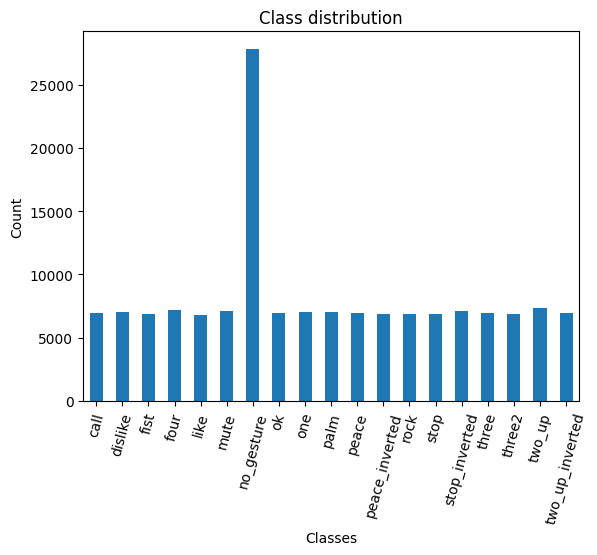

In [11]:
class_counts = pd.DataFrame(dataset['label']).value_counts().sort_index()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names)  # Set the x-axis tick labels
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.show()

### Visualizing Sample Images

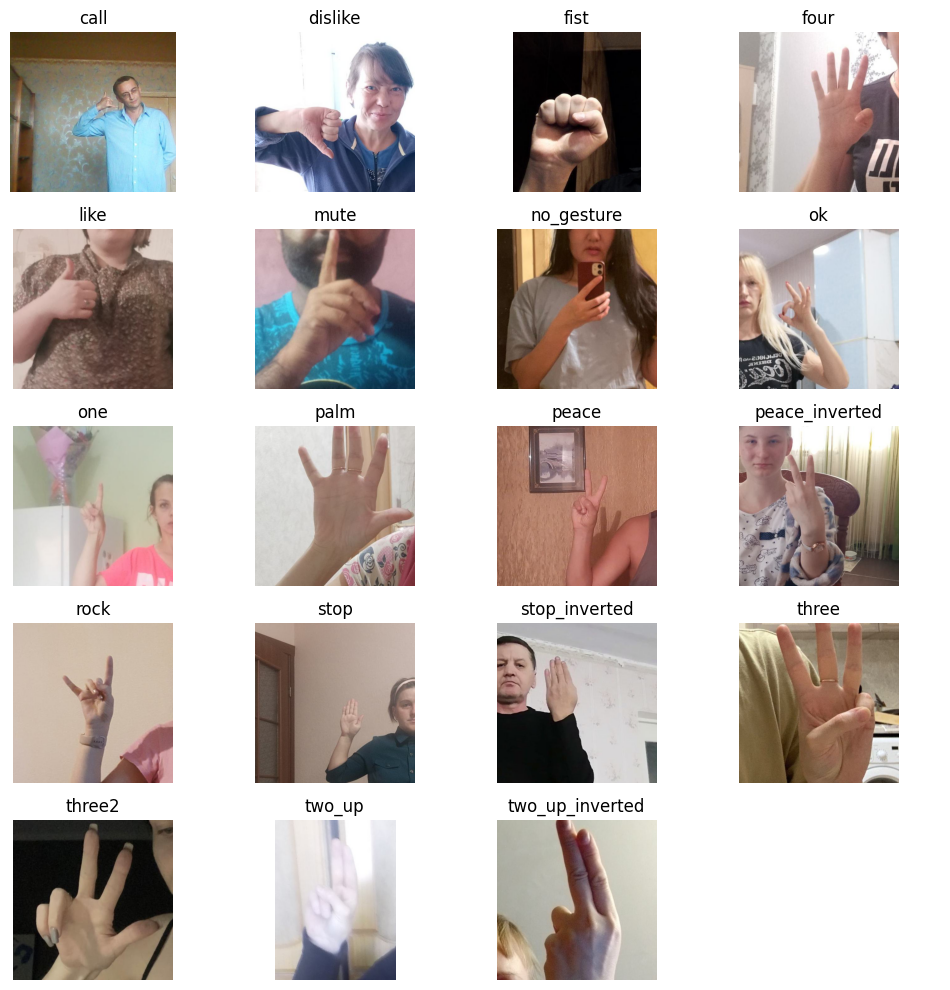

In [12]:
# Get indices for the first sample in the dataset for each class
indices = [dataset['label'].index(value) for value in range(len(class_names)) if value in dataset['label']]

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(indices)))
n_rows = grid_size+(1 if grid_size**2 < len(indices) else 0)
n_cols = grid_size

# Create a list to store the first image found for each class
images = dataset[indices]['image']
labels = dataset[indices]['label']

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(images) and images[i]:
        # Add the image to the subplot
        ax.imshow(np.array(images[i]))
        # Set the title to the corresponding class name
        ax.set_title(class_names[labels[i]])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Selecting a Model

### Exploring Available Models

In [13]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18.a1_in1k
1,resnet18.a2_in1k
2,resnet18.a3_in1k
3,resnet18.fb_ssl_yfcc100m_ft_in1k
4,resnet18.fb_swsl_ig1b_ft_in1k
5,resnet18.gluon_in1k
6,resnet18.tv_in1k
7,resnet18d.ra2_in1k


### Inspecting the ResNet18-D Model Configuration

In [14]:
# Import the resnet module
from timm.models import resnet

# Define the ResNet model variant to use
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model
model_cfg = resnet.default_cfgs[resnet_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
hf_hub_id,timm/
custom_load,False
input_size,"(3, 224, 224)"
test_input_size,"(3, 288, 288)"
fixed_input_size,False
interpolation,bicubic
crop_pct,0.875
test_crop_pct,0.95
crop_mode,center


### Retrieving Normalization Statistics

In [15]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

### Loading the ResNet18-D Model

In [16]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
resnet18 = resnet18.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
resnet18.device = device
resnet18.name = resnet_model

### Selecting the Model

In [17]:
model = resnet18

### Summarizing the Model

In [18]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,ResNet,11.2 M,11.2 M,44.9 M,2.7 G,5.3 G,"[1, 3, 256, 256]","[1, 19]"
2,Conv2d,864,864,3.5 K,14.2 M,14.2 M,"[1, 3, 256, 256]","[1, 32, 128, 128]"
5,Conv2d,9.2 K,9.2 K,36.9 K,150 M,301 M,"[1, 32, 128, 128]","[1, 32, 128, 128]"
8,Conv2d,18.4 K,18.4 K,73.7 K,301 M,603 M,"[1, 32, 128, 128]","[1, 64, 128, 128]"
14,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
19,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
23,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
28,Conv2d,36.9 K,36.9 K,147 K,150 M,301 M,"[1, 64, 64, 64]","[1, 64, 64, 64]"
33,Conv2d,73.7 K,73.7 K,294 K,75.5 M,150 M,"[1, 64, 64, 64]","[1, 128, 32, 32]"
38,Conv2d,147 K,147 K,589 K,150 M,301 M,"[1, 128, 32, 32]","[1, 128, 32, 32]"


## Preparing the Data

### Selecting a Sample Image

Image Label: stop


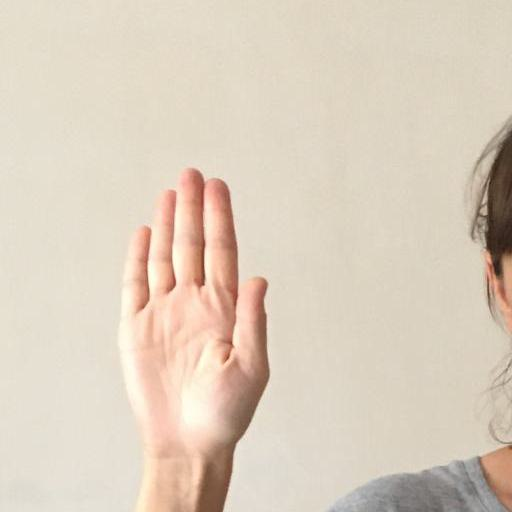

In [19]:
# Select a random item from the dataset
item = random.choice(dataset)

label = class_names[item['label']]
sample_img = item['image']
    
print(f"Image Label: {label}")
    
# Display the image
sample_img

### Data Augmentation

#### Trivial Augmentation

In [20]:
from torch import Tensor
from typing import Dict, Tuple, List, Optional

# This class extends the TrivialAugmentWide class provided by PyTorch's transforms module.
# TrivialAugmentWide is an augmentation policy randomly applies a single augmentation to each image.
class CustomTrivialAugmentWide(transforms.TrivialAugmentWide):
    # The _augmentation_space method defines a custom augmentation space for the augmentation policy.
    # This method returns a dictionary where each key is the name of an augmentation operation and 
    # the corresponding value is a tuple of a tensor and a boolean value.
    # The tensor defines the magnitude of the operation, and the boolean defines  
    # whether to perform the operation in both the positive and negative directions (True)
    # or only in the positive direction (False).
    def _augmentation_space(self, num_bins: int) -> Dict[str, Tuple[Tensor, bool]]:
        
        # Define custom augmentation space
        custom_augmentation_space = {
            # Identity operation doesn't change the image
            "Identity": (torch.tensor(0.0), False),
            
            # Distort the image along the x or y axis, respectively.
            "ShearX": (torch.linspace(0.0, 0.25, num_bins), True),
            "ShearY": (torch.linspace(0.0, 0.25, num_bins), True),

            # Move the image along the x or y axis, respectively.
            "TranslateX": (torch.linspace(0.0, 32.0, num_bins), True),
            "TranslateY": (torch.linspace(0.0, 32.0, num_bins), True),

            # Rotate operation: rotates the image.
            "Rotate": (torch.linspace(0.0, 45.0, num_bins), True),

            # Adjust brightness, color, contrast,and sharpness respectively.
            "Brightness": (torch.linspace(0.0, 0.75, num_bins), True),
            "Color": (torch.linspace(0.0, 0.99, num_bins), True),
            "Contrast": (torch.linspace(0.0, 0.99, num_bins), True),
            "Sharpness": (torch.linspace(0.0, 0.99, num_bins), True),

            # Reduce the number of bits used to express the color in each channel of the image.
            "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),

            # Invert all pixel values above a threshold.
            "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),

            # Maximize the image contrast by setting the darkest color to black and the lightest to white.
            "AutoContrast": (torch.tensor(0.0), False),

            # Equalize the image histogram to improve its contrast.
            "Equalize": (torch.tensor(0.0), False),
        }
        
        # The function returns the dictionary of operations.
        return custom_augmentation_space

#### Test the transform

torch.Size([1, 3, 512, 512])


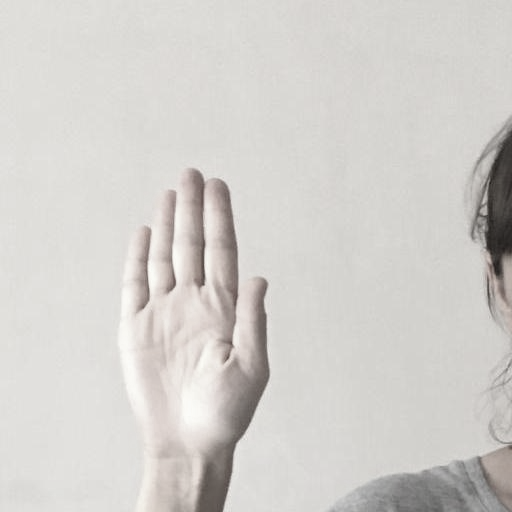

In [21]:
# Create a TrivialAugmentWide object
trivial_aug = CustomTrivialAugmentWide()

# Convert the image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)[None]
print(img_tensor.shape)

# Apply the TrivialAugmentWide to the tensor
tensor_to_pil(trivial_aug(img_tensor))

### Training-Validation Split

In [22]:
# Define the percentage of the images that should be used for validation
val_pct = 0.1

# Split the dataset into training and validation sets
train_split, val_split = dataset.train_test_split(test_size=val_pct).values()

# Print the number of images in the training and validation sets
len(train_split), len(val_split)

(138361, 15374)

### Image Resizing and Padding

#### Resize Pad Transform

In [23]:
class ResizePad(nn.Module):
    def __init__(self, max_sz=256, padding_mode='edge'):
        """
        A PyTorch module that resizes an image tensor and adds padding to make it a square tensor.

        Args:
        max_sz (int, optional): The size of the square tensor.
        padding_mode (str, optional): The padding mode used when adding padding to the tensor.
        """
        super().__init__()
        self.max_sz = max_sz
        self.padding_mode = padding_mode
        
    def forward(self, x):
        # Get the width and height of the image tensor
        w, h = TF.get_image_size(x)
        
        # Resize the image tensor so that its minimum dimension is equal to `max_sz`
        size = int(min(w, h) / (max(w, h) / self.max_sz))
        x = TF.resize(x, size=size, antialias=True)
        
        # Add padding to make the image tensor a square
        w, h = TF.get_image_size(x)
        offset = (self.max_sz - min(w, h)) // 2
        padding = [0, offset] if h < w else [offset, 0]
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode)
        x = TF.resize(x, size=[self.max_sz] * 2, antialias=True)
        
        return x

#### Set training image size

In [24]:
train_sz = (288,288)

#### Test the transform

Source image: (512, 512)
Cropped image: (512, 256)
Cropped tensor: torch.Size([1, 3, 256, 512])
Padded tensor: torch.Size([1, 3, 288, 288])


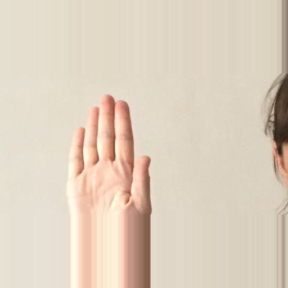

In [25]:
print(f"Source image: {sample_img.size}")

# Crop the source image
w, h = sample_img.size
cropped_img = sample_img.crop([0, h//4, w, h-h//4])
print(f"Cropped image: {cropped_img.size}")

# Create a `ResizePad` object
resize_pad = ResizePad(max_sz=max(train_sz))

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(cropped_img)[None]
print(f"Cropped tensor: {img_tensor.shape}")

# Resize and pad the tensor
resized_tensor = resize_pad(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Display the updated image
tensor_to_pil(resized_tensor)

### Training Dataset Class

In [26]:
class ImageDataset(Dataset):
    """A PyTorch Dataset class to be used in a DataLoader to create batches.
    
    Attributes:
        dataset: A list of dictionaries containing 'label' and 'image' keys.
        classes: A list of class names.
        tfms: A torchvision.transforms.Compose object combining all the desired transformations.
    """
    def __init__(self, dataset, classes, tfms):
        self.dataset = dataset
        self.classes = classes
        self.tfms = tfms
        
    def __len__(self):
        """Returns the total number of samples in this dataset."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """Fetches a sample from the dataset at the given index.
        
        Args:
            idx: The index to fetch the sample from.
            
        Returns:
            A tuple of the transformed image and its corresponding label index.
        """
        sample = self.dataset[idx]
        image, label = sample['image'], sample['label']
        return self.tfms(image), label

### Image Transforms

In [27]:
# Define the transformations for training and validation datasets
# Note: Data augmentation is performed only on the training dataset
train_tfms = transforms.Compose([
    ResizePad(max_sz=max(train_sz)),
    trivial_aug,
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
])

valid_tfms = transforms.Compose([
    ResizePad(max_sz=max(train_sz)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_stats),
])

### Initialize Datasets

In [28]:
# Instantiate the datasets using the defined transformations
train_dataset = ImageDataset(dataset=train_split, classes=class_names, tfms=train_tfms)
valid_dataset = ImageDataset(dataset=val_split, classes=class_names, tfms=valid_tfms)

# Print the number of samples in the training and validation datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')

Training dataset size: 138361
Validation dataset size: 15374


### Inspect Samples

**Inspect training set sample**

Label: dislike


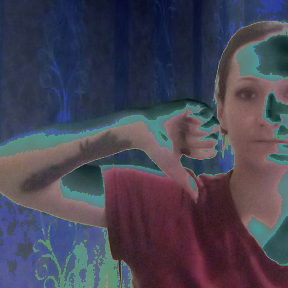

In [29]:
# Get the label for the first image in the training set
print(f"Label: {train_dataset.classes[train_dataset[0][1]]}")

# Get the first image in the training set
tensor_to_pil(denorm_img_tensor(train_dataset[0][0], *norm_stats))

**Inspect validation set sample**

Label: no_gesture


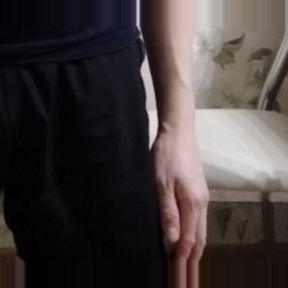

In [30]:
# Get the label for the first image in the validation set
print(f"Label: {valid_dataset.classes[valid_dataset[0][1]]}")

# Get the first image in the validation set
tensor_to_pil(denorm_img_tensor(valid_dataset[0][0], *norm_stats))

### Training Batch Size

In [31]:
bs = 32

### Initialize DataLoaders

In [32]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': True,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device,  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_dataloader)}')
print(f'Number of batches in validation DataLoader: {len(valid_dataloader)}')

Number of batches in train DataLoader: 4324
Number of batches in validation DataLoader: 481


## Fine-tuning the Model

### Define the Training Loop

In [33]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()
    
    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch 
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")
    
    # Iterate over data batches
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device (e.g., GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            with autocast(device):
                outputs = model(inputs) # Forward pass
                loss = torch.nn.functional.cross_entropy(outputs, targets) # Compute loss
        
        # Update the performance metric
        metric.update(outputs.detach().cpu(), targets.detach().cpu())
        
        # If in training mode
        if is_training:
            if scaler is not None: # If using AMP
                # Scale the loss and backward propagation
                scaler.scale(loss).backward()
                scaler.step(optimizer) # Make an optimizer step
                scaler.update() # Update the scaler
            else:
                loss.backward() # Backward propagation
                optimizer.step() # Make an optimizer step
            
            optimizer.zero_grad() # Clear the gradients
            lr_scheduler.step() # Update learning rate
        
        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(accuracy=metric.compute().item(), 
                                 loss=loss_item, 
                                 avg_loss=epoch_loss/(batch_id+1), 
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()
        
        # If loss is NaN or infinity, stop training
        if math.isnan(loss_item) or math.isinf(loss_item):
            print(f"Loss is NaN or infinite at epoch {epoch}, batch {batch_id}. Stopping training.")
            break
        
    progress_bar.close()
    return epoch_loss / (batch_id + 1)

In [34]:
# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, use_amp, checkpoint_path):
    # Initialize GradScaler for Automatic Mixed Precision (AMP) if 'use_amp' is True
    scaler = GradScaler() if use_amp else None
    best_loss = float('inf')

    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, is_training=True)
        
        with torch.no_grad():
            # Run validation epoch and compute validation loss
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, is_training=False)
        
        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            torch.save(model.state_dict(), checkpoint_path)
            
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            
            # Save best_loss and metric_value in a JSON file
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

        # If loss is NaN or infinity, stop training
        if any(math.isnan(loss) or math.isinf(loss) for loss in [train_loss, valid_loss]):
            print(f"Loss is NaN or infinite at epoch {epoch}. Stopping training.")
            break

    # If using AMP, clean up the unused memory in GPU
    if use_amp:
        torch.cuda.empty_cache()

### Set the Model Checkpoint Path

In [35]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

pytorch-timm-image-classifier/2023-08-12_15-55-52/resnet18d.pth


### Configure the Training Parameters

In [36]:
# Learning rate for the model
lr = 1e-3

# Number of training epochs
epochs = 3

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

# Performance metric: Multiclass Accuracy
metric = MulticlassAccuracy()

# Check for CUDA-capable GPU availability
use_amp = torch.cuda.is_available()

### Train the Model

In [37]:
train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, use_amp, checkpoint_path)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Train:   0%|          | 0/4324 [00:00<?, ?it/s]

Eval:   0%|          | 0/481 [00:00<?, ?it/s]

Train:   0%|          | 0/4324 [00:00<?, ?it/s]

Eval:   0%|          | 0/481 [00:00<?, ?it/s]

Train:   0%|          | 0/4324 [00:00<?, ?it/s]

Eval:   0%|          | 0/481 [00:00<?, ?it/s]

## Making Predictions with the Model

Target Class:           like
Predicted Class:        like
Confidence Score:    100.00%


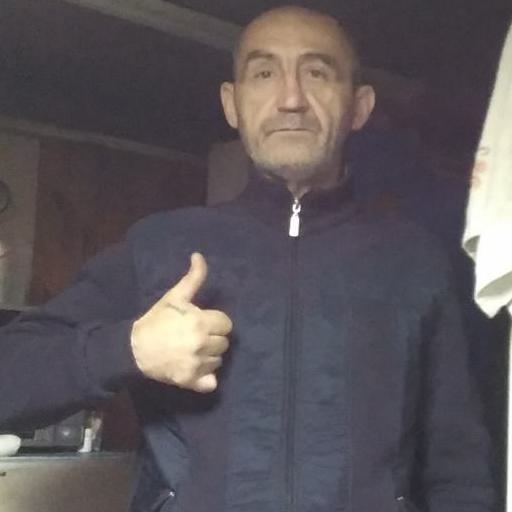

In [38]:
# Set the minimum input dimension for inference 
infer_sz = max(train_sz)

# Choose a random item from the dataset
item = random.choice(dataset)

# Open the image and resize it
sample_img = item['image']
inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = train_dataset.classes[torch.argmax(pred_scores)]

# Store the prediction data in a Pandas Series for easy formatting
pred_data = pd.Series({
    "Target Class:": class_names[item['label']],
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
})

# Print the prediction data
print(pred_data.to_string(header=False))

# Display the image
sample_img

### Testing the Model on New Data

Image already exists.


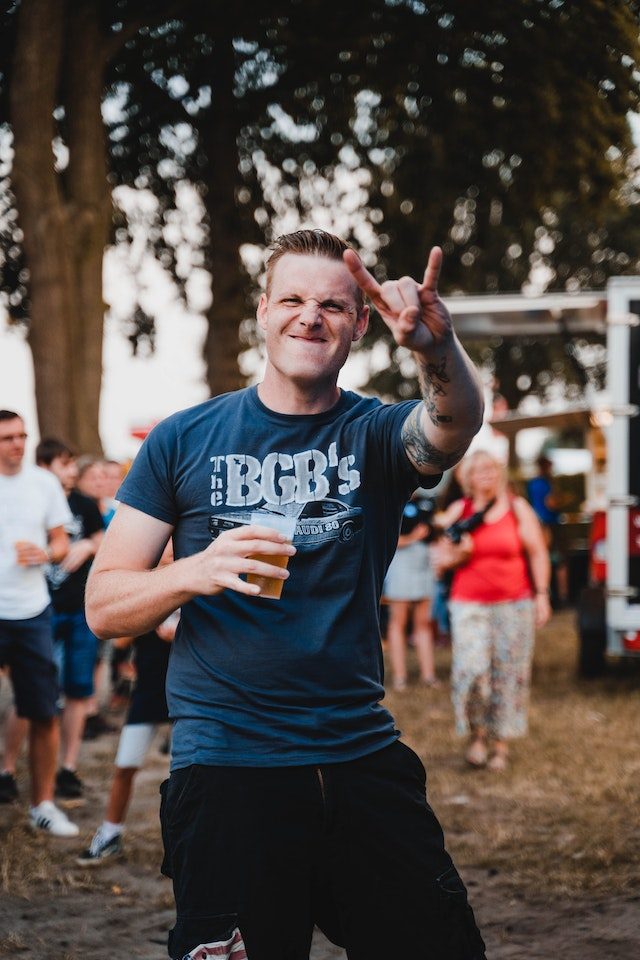

In [39]:
import urllib.request

test_img_url = "https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/pexels-2769554-man-doing-rock-and-roll-sign.jpg"
test_img_path = Path("./pexels-man-doing-rock-and-roll-sign.jpg")

if test_img_path.is_file():
    print("Image already exists.")
else:
    urllib.request.urlretrieve(test_img_url, test_img_path)
    print("Image downloaded.")

sample_img = Image.open(test_img_path)
sample_img

Input Size:          (288, 416)
Target Class:              rock
Predicted Class:           rock
Confidence Score:        73.72%


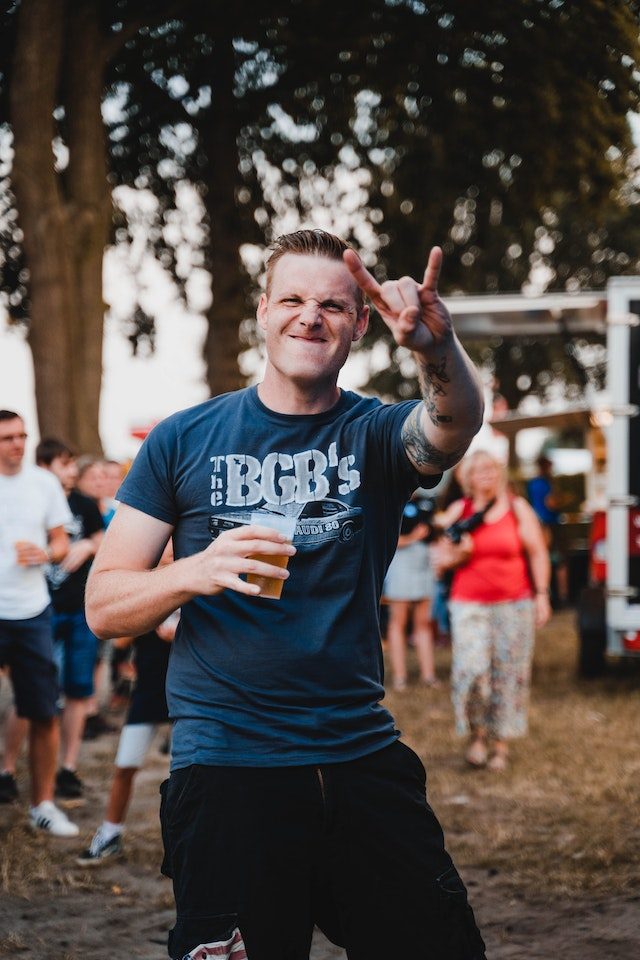

In [40]:
target_cls = "rock"

# Set the minimum input dimension for inference 
infer_sz = max(train_sz)

inp_img = resize_img(sample_img.copy(), infer_sz)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)
        
# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = train_dataset.classes[torch.argmax(pred_scores)]

# Store the prediction data in a Pandas Series for easy formatting
pred_data = pd.Series({
    "Input Size:": inp_img.size,
    "Target Class:": target_cls,
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
})

# Print the prediction data
print(pred_data.to_string(header=False))

# Display the image
sample_img

### Saving the Class Labels

In [41]:
# Save class labels
class_labels = {"classes": list(train_dataset.classes)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)
    
print(class_labels_path)

pytorch-timm-image-classifier/2023-08-12_15-55-52/hagrid-classification-512p-no-gesture-150k-zip-classes.json
